In [1]:
import matplotlib.pyplot as plt
%matplotlib inline 

import numpy as np
import pandas as pd

In [30]:
df = pd.read_csv('seeds_dataset.csv', header = None)
df.head()

print (df.columns)

Int64Index([0, 1, 2, 3, 4, 5, 6, 7], dtype='int64')


In [31]:
# change integer column names to strings

df.columns = df.columns.map(str)
print (df.columns)

Index(['0', '1', '2', '3', '4', '5', '6', '7'], dtype='object')


In [32]:
# change class labels to numbers starting from 0

df['7'] = df['7'] - 1

In [33]:
seed_x = df[df.columns[: -1]]
seed_y = df[df.columns[-1]]

In [6]:
# # Generate a dataset and plot it
# import sklearn.datasets

# np.random.seed(0)
# x, y = sklearn.datasets.make_moons(200, noise = 0.20)
# plt.scatter(x[:,0], x[:,1], s = 40, c = y, cmap = plt.cm.Spectral)

forward propagation

$$
\begin{aligned}
z_1 = xW_1 + b_1 \\
a_1 = \tanh(z_1) \\
z_2 = a_1W_2 + b_2 \\
a_2 = \hat{y} = \mathrm{softmax}(z_2)
\end{aligned}
$$

back propagation

$$
\begin{aligned}
\delta_3 = \hat{y} - y \\
\frac{\partial{L}}{\partial{W_2}} = a_1^T \delta_3  \\
\frac{\partial{L}}{\partial{W_1}} = x^T \delta_2\\
\delta_2 = (1 - \tanh^2z_1) \circ \delta_3W_2^T \\
\frac{\partial{L}}{\partial{b_2}} = \delta_3\\
\frac{\partial{L}}{\partial{b_1}} = \delta_2 \\
\end{aligned}
$$

cross-entropy loss for softmax function

$$
\begin{aligned}
L(y,\hat{y}) = - \frac{1}{N} \sum_{n \in N} \sum_{i \in C} y_{n,i} \log\hat{y}_{n,i}
\end{aligned}
$$

In [23]:
# num_examples = len(x) # training data size
# nn_input_dim = 2 # input layer dimension
# nn_output_dim = 2 # output layer dimension 


num_examples = seed_x.shape[0]
nn_input_dim = len(seed_x.iloc[1])
nn_output_dim = len(seed_y.unique())


# gradient descent parameters - picked randomly for now
epsilon = 0.001 # learning rate for gradient descent
reg_lambda = 0.1 # regularization


In [8]:
# evaluate total loss on the dataset

def calculate_loss(model, x, y):
    w1, b1, w2, b2 = model['w1'], model['b1'], model['w2'], model['b2']
    
    # forward propagation
    z1 = x.dot(w1) + b1
    a1 = np.tanh(z1)
    z2 = a1.dot(w2) + b2
    # soft max for two dimensional output
    exp_scores = np.exp(z2)
    probs = exp_scores/ np.sum(exp_scores, axis = 1, keepdims = True)
    
    # cross-entropy loss
    corect_logprobs = -np.log(probs[range(num_examples), y])
    data_loss = np.sum(corect_logprobs)
    # add regularization term to loss function
    data_loss += reg_lambda/2 * (np.sum(np.square(w1)) + np.sum(np.square(w2)))
    
    return 1/ num_examples * data_loss

In [9]:
# output prediction - output layer dimension is determined by the number of classes, each neuron standing for a class
def predict(model, x):
    w1, b1, w2, b2 = model['w1'], model['b1'], model['w2'], model['b2']
    
    # forward propagation
    z1 = x.dot(w1) + b1
    a1 = np.tanh(z1)
    z2 = a1.dot(w2) + b2
    # soft max for J dimensional output
    exp_scores = np.exp(z2)
    probs = exp_scores/ np.sum(exp_scores, axis = 1, keepdims = True)
    
    return np.argmax(probs, axis = 1)


In [93]:
# nn_hdim: Number of neurons in the hidden layer
# num_passes: Number of passes through the training data for gradient descent
# print_loss: If True, print the loss every 1000 iterations

def build_model(x, y, nn_hdim, num_passes = 200000, print_loss = False):
    
    # parameter initialization
    np.random.seed(0)
    w1 = np.random.randn(nn_input_dim, nn_hdim)/ np.sqrt(nn_input_dim)
    b1 = np.zeros((1, nn_hdim))
    w2 = np.random.rand(nn_hdim, nn_output_dim)/ np.sqrt(nn_hdim)
    b2 = np.zeros((1, nn_output_dim))
    
    model = {}
    loss = []
    
    # batch gradient descent
    for i in range(0, num_passes):
        
        # forward propagation
        z1 = x.dot(w1) + b1
        a1 = np.tanh(z1)
        z2 = a1.dot(w2) + b2
        # soft max for two dimensional output
        exp_scores = np.exp(z2)
        probs = exp_scores/ np.sum(exp_scores, axis = 1, keepdims = True)
    
        # backpropagation
        delta3 = probs
        delta3[range(num_examples), y] -= 1
        dw2 = (a1.T).dot(delta3)
        db2 = np.sum(delta3, axis = 0, keepdims = True)
        delta2 = delta3.dot(w2.T) * (1 - np.power(a1, 2))
        dw1 = np.dot(x.T, delta2)
        db1 = np.sum(delta2, axis = 0)
        
        # add regularization terms
        dw2 += reg_lambda * w2
        dw1 += reg_lambda * w1
        
        # update gradient descent parameter
        w1 += - epsilon * dw1
        b1 += - epsilon * db1 
        w2 += - epsilon * dw2
        b2 += - epsilon * db2
        
        # assign updated parameters to the model
        model = {'w1': w1, 'b1': b1, 'w2': w2, 'b2': b2}
        
        # print the loss optionally 
        if print_loss and i % 20000 == 0:
            print('Loss after iteration %i: %f' %(i, calculate_loss(model, x, y)))
            
        if i % 2000 == 0:
            loss.append(calculate_loss(model, x, y))
    
    return model, loss

In [37]:
# def plot_decision_boundary(pred_func):
#     # Set min and max values and give it some padding
#     x_min, x_max = x[:, 0].min() - .5, x[:, 0].max() + .5
#     y_min, y_max = x[:, 1].min() - .5, x[:, 1].max() + .5
#     h = 0.01
    
#     # Generate a grid of points with distance h between them
#     xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
    
#     # Predict the function value for the whole gid
#     Z = pred_func(np.c_[xx.ravel(), yy.ravel()])
#     Z = Z.reshape(xx.shape)
    
#     # Plot the contour and training examples
#     fig = plt.figure(figsize = (7, 5))
#     plt.contourf(xx, yy, Z, cmap = plt.cm.Spectral)
#     plt.scatter(x[:, 0], x[:, 1], c = y, cmap = plt.cm.Spectral, alpha = 0.7)

In [60]:
# use the network above to train 5 neuron a single hidden layer nn

# model = build_model(x, y, 3, print_loss = True)

model, loss = build_model(np.array(seed_x), np.array(seed_y), 5, print_loss = True)


Loss after iteration 0: 1.022415
Loss after iteration 20000: 1.103004
Loss after iteration 40000: 0.586528
Loss after iteration 60000: 1.105641
Loss after iteration 80000: 1.101040
Loss after iteration 100000: 1.100700
Loss after iteration 120000: 1.100224
Loss after iteration 140000: 1.106169
Loss after iteration 160000: 1.101719
Loss after iteration 180000: 1.105909


In [61]:
pred = predict(model, np.array(seed_x))
pred

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 2, 0, 0, 2, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0,
       0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 2, 0, 0, 0, 0, 0,
       2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0,
       0, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 2, 0, 2, 2, 2, 2, 2,
       2, 2, 2])

In [62]:
# accuracy 

def accuracy(model, x, y_true):
    pred = predict(model, x)

    return sum(pred == y_true)/ y_true.shape[0]

In [63]:
# accuracy

accuracy(model, np.array(seed_x), np.array(seed_y))

0.90952380952380951

In [53]:
# plot_decision_boundary(lambda x: predict(model, x))

### loss and number of hidden layers 

In [97]:
# 3, 5, 7, 10 neuron single layer model

model3, loss3 = build_model(np.array(seed_x), np.array(seed_y), 3, print_loss = False)
model5, loss5 = build_model(np.array(seed_x), np.array(seed_y), 5, print_loss = False)
model7, loss7 = build_model(np.array(seed_x), np.array(seed_y), 7, print_loss = False)
model10, loss10 = build_model(np.array(seed_x), np.array(seed_y), 10, print_loss = False)

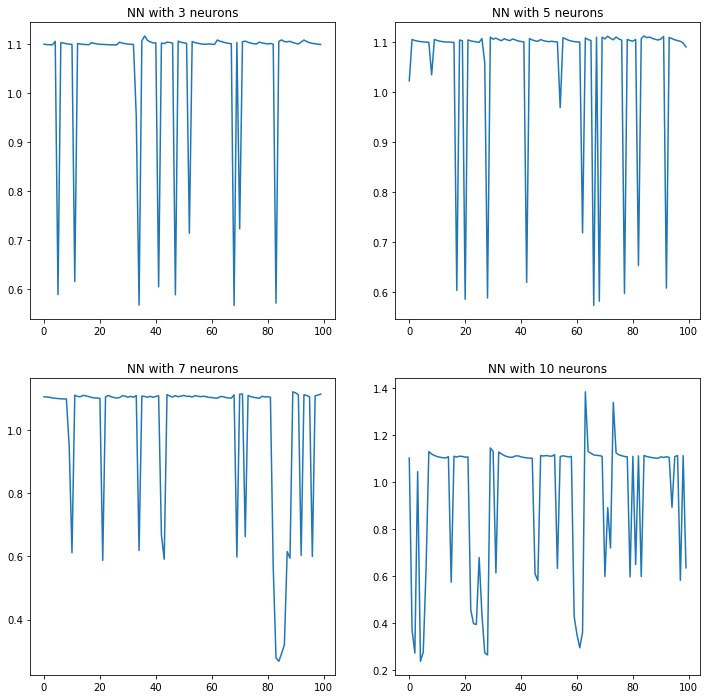

In [98]:
fig = plt.figure(figsize = (12, 12))
# x axis - epochs
# y axis - loss

plt.subplot(221)
plt.plot(loss3)
plt.title('NN with 3 neurons')

plt.subplot(222)
plt.plot(loss5)
plt.title('NN with 5 neurons')

plt.subplot(223)
plt.plot(loss7)
plt.title('NN with 7 neurons')

plt.subplot(224)
plt.plot(loss10)
plt.title('NN with 10 neurons')

In [100]:
for i in [model3, model5, model7, model10]:
    print (accuracy(i, np.array(seed_x), np.array(seed_y)))

0.333333333333
0.909523809524
0.333333333333
0.638095238095
